# AUTO-PLATE-RECOGNITION
#### UCLA CS145 - Professor Si Si
#### TEAM NAME: Deep Learners
----
#### TEAM MEMBERS:
Caleb Lee   UID: 305-330-193    Email: bkcaleb45@g.ucla.edu 

Dylan Phe	UID: 505-834-475	Email: dylanphe@g.ucla.edu

Kevin Wang	UID:  305-503-382      Email: kwang1083@g.ucla.edu

---

The goal of our project is to use machine learning algorithms learned in class and through further research to train a model to extract and recognize US vehicle license plate numbers from images. This project will involve comparing performances between different machine learning models, as well as taking into account their complexity, training times, and memory efficiency. The metrics we aim to compare mainly include F1 score, precision, recall, and accuracy. We will train and test the performance of these algorithms on a dataset of car images with varying lighting conditions, backgrounds, and license plate sizes. 


## I. Importing the necessary packages

In our project, we will make use of well-known tools and packages like NumPy, pandas, matplotlib, cv2, and scipy. These libraries will help us preprocess license plate images for both training and prediction in our classification problem. Furthermore, we will integrate Keras, an open-source software library, to implement various training models for making predictions and analyzing their outcomes. As we are working within a Colab notebook environment, we will also need to import the required APIs to access image files from Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/AUTO-PLATE/auto-plate-detector-main'

/content/drive/MyDrive/AUTO-PLATE/auto-plate-detector-main


In [3]:
import os
import random
import csv
import numpy as np
import pandas as pd
import keras
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, Model
from keras.applications import ResNet50
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D

import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter

## II. Preparing and Pre-Procesing the Dataset

### 2.(a). Loading and Visualizing the dataset 

The dataset consists of 2,951 images of license plates from all 51 U.S. states, which was obtained from the following sources: https://www.kaggle.com/code/tolgadincer/us-license-plates-data-quick-overview/input?select=data, https://platesmania.com/us/gallery-1. We then organized this data into a table format of dimensions 2,951x2(file_list.csv). Each entry in the table contains two attributes, namely "Label" and "Image", which serve to identify each image file along with its corresponding label. In addition, we also split them into the training dataset(train_data.csv) and the testing dataset(test_data.csv). The process to achieve this is as follows:

In [ ]:
# Directory path
dataset_path = 'dataset'

# CSV file path
csv_file = 'file_list.csv'
test_data_file = 'test_data.csv'
train_data_file = 'train_data.csv'

# Function to get the file list in a directory
def get_file_list(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(file)
    return file_list

# Check if the CSV files already exist
csv_file_exists = os.path.exists(csv_file)
test_data_file_exists = os.path.exists(test_data_file)
train_data_file_exists = os.path.exists(train_data_file)

# Generate CSV file if it doesn't exist
if not csv_file_exists:
    # Get directory list in /dataset
    directories = [directory for directory in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, directory))]

    # Open the CSV file in write mode
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Iterate through directories
        for directory in directories:
            # Get file list in the current directory
            file_list = get_file_list(os.path.join(dataset_path, directory))

            # Write file list to CSV
            for file_name in file_list:
                writer.writerow([directory, file_name])

    print("CSV file generated successfully.")
else:
    print("CSV file already exists. Skipping generation.")

# Read the data from the original CSV file if it exists
data = []
if csv_file_exists:
    with open(csv_file, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            data.append(row)

    # Shuffle the data randomly
    random.shuffle(data)

    # Calculate the split index
    split_index = int(len(data) * 9 / 10)

    # Split the data into test and train sets
    train_data = data[:split_index+1]
    test_data = data[split_index:]

    # Write test data to CSV if it doesn't exist
    if not test_data_file_exists:
        with open(test_data_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Label', 'Image'])  # Header
            writer.writerows(test_data)
        print("Test data CSV file generated successfully.")
    else:
        print("Test data CSV file already exists. Skipping generation.")

    # Write train data to CSV if it doesn't exist
    if not train_data_file_exists:
        with open(train_data_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Label', 'Image'])  # Header
            writer.writerows(train_data)
        print("Train data CSV file generated successfully.")
    else:
        print("Train data CSV file already exists. Skipping generation.")

    print("Data separation completed successfully.")


CSV file already exists. Skipping generation.
Test data CSV file already exists. Skipping generation.
Train data CSV file already exists. Skipping generation.
Data separation completed successfully.


After the csv files were created, we utilized pandas to read both the train_data.csv and the test_data.csv and converted them into train and test dataframes as shown below. The training dataframe should contain 2951 rows whereas the testing dataset should contain 328 rows. The proportion of the split is 9:1.

In [4]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
print(f"Training data = {train.shape}")
print(f"Testing data = {test.shape}")
train

Training data = (2951, 2)
Testing data = (328, 2)


,Label,Image
0,Missouri,c2279f4a173509.jpg
1,SouthDakota,e0a2bee82c7b29.jpg
2,Pennsylvania,4dc2772e7e3ddd.jpg
3,Massachusetts,21685515aa4999.png
4,Delaware,ae03d6f2677fa4.jpg
...,...,...
2946,Michigan,21680287dfe37d.png
2947,Florida,21572733ecdb1b.png
2948,Washington,4ed9656a5fd7b4.jpg
2949,Virginia,b1b47d79cd01b9.jpg


Given the tables above, we can easily obtain the image files and its corresponding true labels from the dataframes while also being able to distinguish between the two for the purposes of trainings and making predictions. The code below is written and executed as a mean to visualize our dataset.

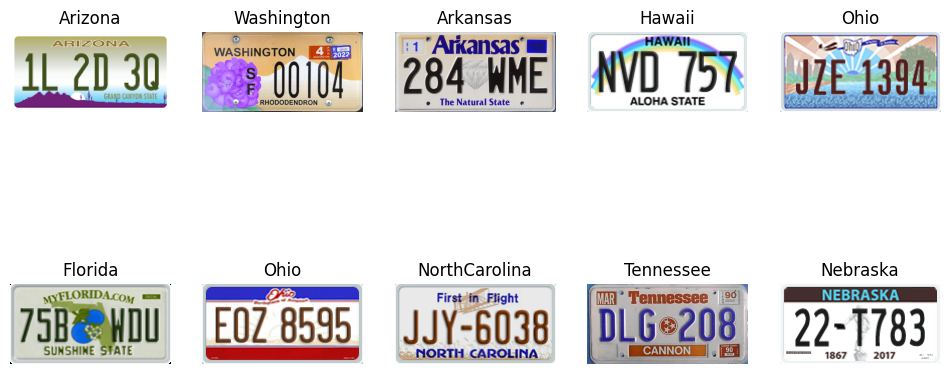

In [ ]:
random.seed(2)
sample = random.sample(list(train.index), 10)

fig, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.flatten()

for i, idx in enumerate(sample):
    path = '/content/drive/MyDrive/auto-plate-detector/dataset/' + train.loc[idx, 'Label'] + '/' + train.loc[idx, 'Image']
    img = cv2.imread(path)
    ax[i].imshow(img)
    ax[i].set_title(train.loc[idx, 'Label'])
    ax[i].axis('off')
plt.show()

### 2.(b) Pre-Processing and Spliting the dataset into the training, validation, and test datasets

In order to enhance the visibility of the State's name letters against the background in our image dataset, we employ several pre-processing steps. 
1. Resize the image so that they are of the same dimension. 
2. Increase the image intensity via convertScaleAbs() by applying an alpha value of 1 and a beta value of 2. This adjustment helps to amplify the overall brightness of the image. 
3. Convert the images to grayscale, simplifying the color information and focusing solely on the grayscale intensity values. 
4. Since the State's names typically appear at the top or bottom of the license plate, we split the images into these specific regions. By isolating these regions, we can concentrate our training efforts on the areas where the State's names are commonly located.
5. Enhance the image one final time to ensure optimal visibility of the letters by inverting between the white and the dark part of the images if they reached a certain threshold.
6. Normalized the images.

By following these pre-processing steps, we ensure that the State's name letters are distinguishable from the background, thus facilitating subsequent analysis and recognition tasks.

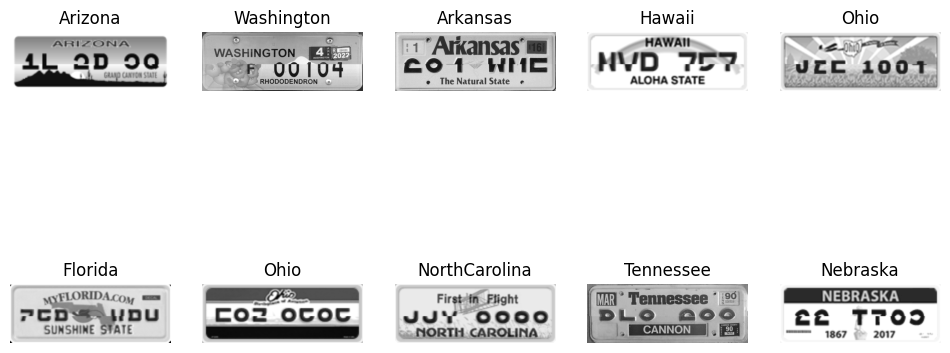

In [ ]:
random.seed(2)
sample = random.sample(list(train.index), 10)

fig, ax = plt.subplots(2, 5, figsize=(12, 6))
ax = ax.flatten()

for i, idx in enumerate(sample):
    path = '/content/drive/MyDrive/auto-plate-detector/dataset/' + train.loc[idx, 'Label'] + '/' + train.loc[idx, 'Image']
    img = cv2.imread(path)
    img = cv2.resize(img, (1000, 500))
    
    img = cv2.convertScaleAbs(img, alpha=1, beta=2)
    
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate the height of the image
    height = img.shape[0]
    
    # Cut the image in half
    top_img = gray_img[0:int((height/2.5)), :]
    bottom_img = gray_img[int(2*(height/3)):height, :]
    
    concat_img = np.concatenate((top_img, bottom_img), axis=0)
    
    # Calculate the average brightness of the image
    average_brightness = np.mean(concat_img)
    
    # Define threshold values for brightness adjustment
    dark_threshold =   60# Adjust this value to determine what is considered dark
    
    if average_brightness < dark_threshold:
        # Invert the dark and light parts of the image
        concat_img = cv2.bitwise_not(concat_img)
        
    # Increase the contrast between letters and background
    #concat_img = cv2.bitwise_not(concat_img)
    enhanced_img = cv2.normalize(concat_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    
    ax[i].imshow(enhanced_img, cmap='gray')
    ax[i].set_title(train.loc[idx, 'Label'])
    ax[i].axis('off')
    #ax[i].imshow(binary_img, cmap='gray')
    #ax[i].set_title(train.loc[idx, 'Label'])
    #ax[i].axis('off')

plt.show()

To prepare our dataset for the training and the prediction stages, we parse the images and append them to their corresponding row within dataframes. However, since there are many data to process and some pcs might not have sufficient memory, we instead split them into eight splits and process them one by one. 

In [5]:
from multiprocessing import Pool

def split_data(data, parts):
    # Split the data into the specified number of parts
    splits = np.array_split(data, parts)

    with Pool(processes=parts) as pool:
        # Use the map function to parallelize the parsing process
        result = pool.map(parse_images, splits)
        
    images = []
    labels = []

    for res in result:
        split_images, split_labels = res

        # Append the parsed images and labels to the lists
        images.append(split_images)
        labels.append(split_labels)

    # Concatenate the splits to get the final datasets
    images = np.concatenate(images)
    labels = np.concatenate(labels)

    return images, labels

def parse_images(data):
    images = []
    labels = []

    # Loop through the CSV entries and load each image
    for index, row in data.iterrows():
        img_path = 'dataset/' + row['Label'] + '/' + row['Image']
        img = cv2.imread(img_path)
        if img is not None:
          # Resize the image to 500x1000 (looking at img.shape, this is around the average image size)
          img = cv2.resize(img, (1000, 500))
        else:
          print("Image was not read") 
          break
        img = cv2.convertScaleAbs(img, alpha=1, beta=2)
        
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Calculate the height of the image
        height = img.shape[0]
        
        # Cut the image in half
        top_img = gray_img[0:int((height/2.5)), :]
        bottom_img = gray_img[int(2*(height/3)):height, :]
        
        concat_img = np.concatenate((top_img, bottom_img), axis=0)
        
        # Calculate the average brightness of the image
        average_brightness = np.mean(concat_img)
        
        # Define threshold values for brightness adjustment
        dark_threshold =   60# Adjust this value to determine what is considered dark
        
        if average_brightness < dark_threshold:
            # Invert the dark and light parts of the image
            concat_img = cv2.bitwise_not(concat_img)
            
        # Increase the contrast between letters and background
        #concat_img = cv2.bitwise_not(concat_img)
        enhanced_img = cv2.normalize(concat_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        
        images.append(enhanced_img)
        labels.append(row['Label'])
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels



# Split the data into eighths and parse the images
train_valid_X, train_valid_Y = split_data(train, 8)
test_X, test_Y = split_data(test, 8)

#np.save('train_X.npy', train_X)
#np.save('train_Y.npy', train_Y)
#np.save('test_X.npy', test_X)
#np.save('test_Y.npy', test_Y)

In order to give an estimate of each model prediction performance while fine tuning their hyperparameters, we will also withold a sample of the training dataset back from being used to train the model to which we will refer to as the validation dataset. The final shapes of all the three dataframes are shown below.

In [6]:
#train_X = np.load('train_X.npy')
#train_Y = np.load('train_Y.npy')
#test_X = np.load('test_X.npy')
#test_Y = np.load('test_Y.npy')

print("Shape of train X before validation set: ", np.shape(train_valid_X))
print("Shape of train Y before validation set: ", np.shape(train_valid_Y))

#Use 20% of training data for validation
ind_valid = np.random.choice(2951, 500, replace=False)
ind_train = np.array(list(set(range(2951)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(train_X, valid_X) = train_valid_X[ind_train], train_valid_X[ind_valid] 
(train_Y, valid_Y) = train_valid_Y[ind_train], train_valid_Y[ind_valid]

encoder = LabelEncoder()

#encode string labels into integers for SparseCategoricalCrossentropy Loss
train_Y = encoder.fit_transform(train_Y)
valid_Y = encoder.transform(valid_Y)
test_Y = encoder.transform(test_Y)

print("Shape of final train X: ", train_X.shape)
print("Shape of final train y: ", train_Y.shape)

print("Shape of final validation X: ", valid_X.shape)
print("Shape of final valid y: ", valid_Y.shape)
print("Shape of test X: ", np.shape(test_X))
print("Shape of test Y: ", np.shape(test_Y))


Shape of train X before validation set:  (2951, 367, 1000)
Shape of train Y before validation set:  (2951,)
Shape of final train X:  (2451, 367, 1000)
Shape of final train y:  (2451,)
Shape of final validation X:  (500, 367, 1000)
Shape of final valid y:  (500,)
Shape of test X:  (328, 367, 1000)
Shape of test Y:  (328,)


### III.(a) Training Model 1:  5 convolutional blocks with fully connected last layer (CNN - DEEP LEARNING TECHNIQUE)

The CNN model described below is built using the Sequential class from Keras, meaning that the layers are stacked in a linear manner. It consists of a total of 5 convolutional blocks, each followed by 3 additions steps to pre-process the output between feeding it to the next layer of the network. They are as follows:

- A max pooling process that helps in reducting the spatial dimensions and extract out only the relevant features within the image, 
- A batch normalization process to normalizing the activations of the previous layer, which helps in addressing the internal covariate shaft problem, and
- A dropout layer, which is a regularization technique that helps to prevent overfitting in the neural networks. 

In the first convolutional block, the input shape is defined as (367, 1000, 1), representing the dimensions of the license plate images after we had after pre-processing. This block applies a 2D convolution operation with 25 filters and a kernel size of (10,1). The 'elu' activation function is used, and padding is set to 'same' to preserve the spatial dimensions of the input. Max pooling with a pool size of (3,1) reduces the spatial dimensions, and batch normalization helps normalize the output. Dropout with a rate of 0.5 randomly sets a fraction of input units to 0 during training to prevent overfitting. The subsequent convolutional blocks follow a similar structure, with varying filter numbers and kernel sizes. Each block is followed by max pooling, batch normalization, and dropout layers to extract relevant features and reduce overfitting.

The last convolutional block is followed by a flatten layer, which reshapes the output into a 1-dimensional vector. A fully connected layer (Dense) with a softmax activation function is added to produce the final output. The softmax activation assigns probabilities to each class, making it suitable for multi-class classification problems. In this case, the model has 51 classes, corresponding to different license plate labels.

The model summary below provides a concise overview of the model architecture, including the number of parameters in each layer and the output shape at each stage.

In [7]:
# Building the CNN model using sequential class
cnn_model_1 = Sequential()

# Conv. block 1
cnn_model_1.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(367, 1000, 1)))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.4))

# Conv. block 2
cnn_model_1.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.4))

# Conv. block 3
cnn_model_1.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.4))

# Conv. block 4
cnn_model_1.add(Conv2D(filters=10, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.5))

# Conv. block 5
cnn_model_1.add(Conv2D(filters=10, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model_1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model_1.add(BatchNormalization())
cnn_model_1.add(Dropout(0.5))


# Output layer with Softmax activation
cnn_model_1.add(Flatten()) # Flattens the input
cnn_model_1.add(Dense(51, activation='softmax')) # Output FC layer with softmax activation (51 classes)


# Printing the model summary
cnn_model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 367, 1000, 25)     275       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 1000, 25)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 123, 1000, 25)    100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 123, 1000, 25)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 1000, 50)     12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 1000, 50)     0

In [8]:
# Model parameters
learning_rate = 1e-3
epochs = 10
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
cnn_model_1.compile(loss='sparse_categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_1_results = cnn_model_1.fit(train_X,
             train_Y,
             batch_size=3,
             epochs=epochs,
             validation_data=(valid_X, valid_Y), verbose=True)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
817/817 [==============================] - 23s 15ms/step - loss: 3.8898 - accuracy: 0.4276 - val_loss: 2.5343 - val_accuracy: 0.6380
Epoch 2/10
817/817 [==============================] - 12s 14ms/step - loss: 1.2305 - accuracy: 0.7638 - val_loss: 1.2738 - val_accuracy: 0.7560
Epoch 3/10
817/817 [==============================] - 12s 14ms/step - loss: 0.5049 - accuracy: 0.8772 - val_loss: 1.0983 - val_accuracy: 0.8040
Epoch 4/10
817/817 [==============================] - 12s 14ms/step - loss: 0.3242 - accuracy: 0.9086 - val_loss: 1.1539 - val_accuracy: 0.8240
Epoch 5/10
817/817 [==============================] - 12s 14ms/step - loss: 0.1639 - accuracy: 0.9519 - val_loss: 0.9750 - val_accuracy: 0.8440
Epoch 6/10
817/817 [==============================] - 12s 14ms/step - loss: 0.1804 - accuracy: 0.9502 - val_loss: 1.1694 - val_accuracy: 0.7960
Epoch 7/10
817/817 [==============================] - 12s 14ms/step - loss: 0.1220 - accuracy: 0.9657 - val_loss: 1.3240 - val_accuracy:

After the CNN model is constructed, we then proceed to train our model with the training dataset and fine tune its parameters so that a high accuracy prediction could be achieved. As shown in the model and the training process above, we were able to achieve an accuracy of acout 85% on the validation dataset given a model where the dropout values of the first 3 layers of the neural network are reduced to 0.4, and is trained with a learning rate of 0.001 and a batch_size of 3 for a total of 10 iterations. The accuracies and loss trajection of the training process were also then plotted in the figures given below. 

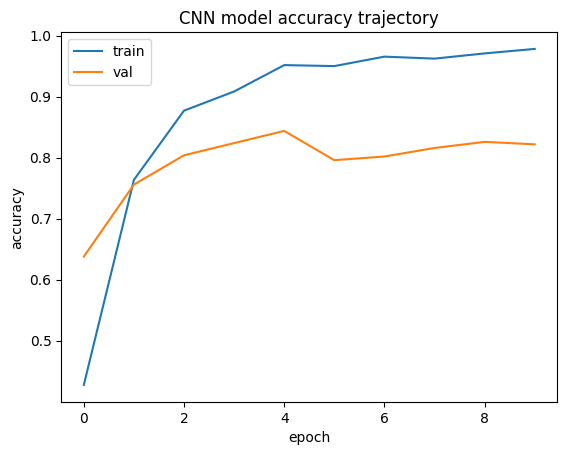

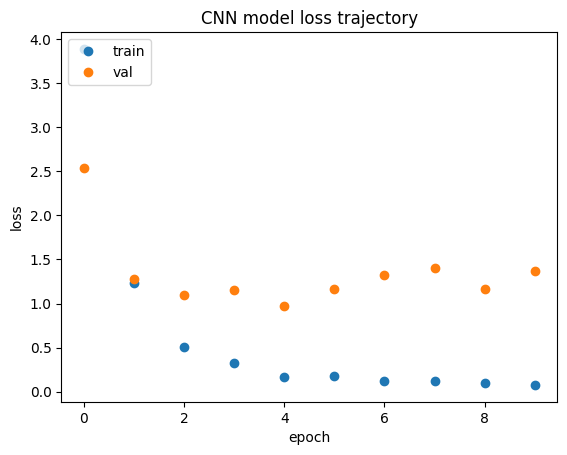

In [9]:
# Plotting accuracy trajectory
plt.plot(cnn_model_1_results.history['accuracy'])
plt.plot(cnn_model_1_results.history['val_accuracy'])
plt.title('CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_1_results.history['loss'],'o')
plt.plot(cnn_model_1_results.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
## Testing the CNN model

cnn_score = cnn_model_1.evaluate(test_X, test_Y, verbose=0)
print('Test accuracy of the CNN model:', cnn_score[1])

Test accuracy of the CNN model: 0.792682945728302


The CNN model achieved a test accuracy of approximately 80%. This indicates that the model performed well in classifying the test data, correctly predicting the labels of license plate images with a high level of accuracy. The test accuracy metric serves as an evaluation of the model's performance on unseen data, giving an indication of its generalization capability. However, it's important to consider the specific requirements and context of the project to determine whether this level of accuracy is satisfactory. Depending on the application and the desired level of performance, the achieved accuracy may be considered good or may require further improvements. Factors such as capturing plate images at random angles, in poor lighting conditions, or while in motion, as well as potential obstructions blocking the view of the state's name, can significantly impact the image quality. These challenging conditions may reduce the accuracy of the model's predictions.

To ensure the model's effectiveness in such scenarios, further improvements may be necessary. This could involve additional data augmentation techniques to simulate challenging conditions during training, or exploring advanced techniques like object detection or image enhancement algorithms. Ultimately, the suitability of the achieved accuracy depends on the project's objectives and desired level of performance. It's important to balance the trade-off between accuracy and real-world practicality, considering the challenges and constraints inherent in license plate image recognition tasks.

### III.(b) Training Model 2: Basic 2 layers Neural Network 

As a contrast to the CNN model that was built using a deep learning technique above, we now focused our attention on a slightly different but less complex algorithm for constructing our next model. The feedforward neural network (FFNN) model that is constructed below also follows a sequential archietecture. The model starts with a Flatten layer that takes input with a shape of (367, 1000, 1) and converts it into a 1-dimensional array. This layer serves as the input layer for the FFNN. Following the Flatten layer is a Dense layer with 256 neurons. The Dense layer applies the rectified linear unit (ReLU) activation function, which helps the model learn complex, non-linear patterns in the data. This layer contributes to the model's ability to extract meaningful features from the input. To prevent overfitting, a Dropout process is also added with a 50% of the input units set to 0 during the training, which effectively drops those units and their connections. This regularization technique helps prevent the model from relying too heavily on specific neurons, promoting better generalization to unseen data. Finally, the model ends with another Dense layer consisting of 51 neurons. This layer uses the softmax activation function, which produces output probabilities for each of the 51 classes in a multi-class classification problem. The softmax activation ensures that the predicted class probabilities sum up to 1, making it suitable for multi-class classification tasks. This summary gives a concise overview of the model's structure.

In [12]:
ffnn_model = Sequential()

ffnn_model.add(Flatten(input_shape=(367, 1000, 1)))
ffnn_model.add(Dense(256, activation='relu'))
ffnn_model.add(Dropout(0.5))
ffnn_model.add(Dense(51, activation='softmax'))  # 51 classes

ffnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 367000)            0         
                                                                 
 dense_1 (Dense)             (None, 256)               93952256  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 51)                13107     
                                                                 
Total params: 93,965,363
Trainable params: 93,965,363
Non-trainable params: 0
_________________________________________________________________


As before, we employed a similar training process that was used earlier on the model. For this model, we used 'sparse_categorical_crossentropy' as our loss function during the optimization process since it is suitable for multi-class classification problems with integer labels. However, we can see that this simple model performed poorly compared to the first model that we have constructed. 

In [13]:
# Model parameters
learning_rate = 1e-3
epochs = 10
nn_optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
ffnn_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=nn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
ffnn_model_results = ffnn_model.fit(train_X,
             train_Y,
             batch_size=3,
             epochs=epochs,
             validation_data=(valid_X, valid_Y), verbose=True)

Epoch 1/10
817/817 [==============================] - 5s 6ms/step - loss: 5671.9980 - accuracy: 0.0257 - val_loss: 3.9325 - val_accuracy: 0.0360
Epoch 2/10
817/817 [==============================] - 4s 5ms/step - loss: 3.9288 - accuracy: 0.0347 - val_loss: 3.9320 - val_accuracy: 0.0360
Epoch 3/10
817/817 [==============================] - 4s 5ms/step - loss: 3.9259 - accuracy: 0.0347 - val_loss: 3.9308 - val_accuracy: 0.0360
Epoch 4/10
817/817 [==============================] - 4s 5ms/step - loss: 3.9243 - accuracy: 0.0347 - val_loss: 3.9303 - val_accuracy: 0.0360
Epoch 5/10
817/817 [==============================] - 4s 5ms/step - loss: 3.9231 - accuracy: 0.0347 - val_loss: 3.9298 - val_accuracy: 0.0360
Epoch 6/10
817/817 [==============================] - 4s 5ms/step - loss: 3.9224 - accuracy: 0.0347 - val_loss: 3.9298 - val_accuracy: 0.0360
Epoch 7/10
817/817 [==============================] - 4s 5ms/step - loss: 3.9219 - accuracy: 0.0347 - val_loss: 3.9299 - val_accuracy: 0.0360
Epo

These results show the training and validation loss values, as well as the training and validation accuracy values at each epoch. It appears that the model is not learning effectively, as the loss and accuracy values do not show significant improvements over the epochs. The training and validation accuracies remain consistently low at approximately 0.036, and the loss values remain high as shown in the plotted figures below.

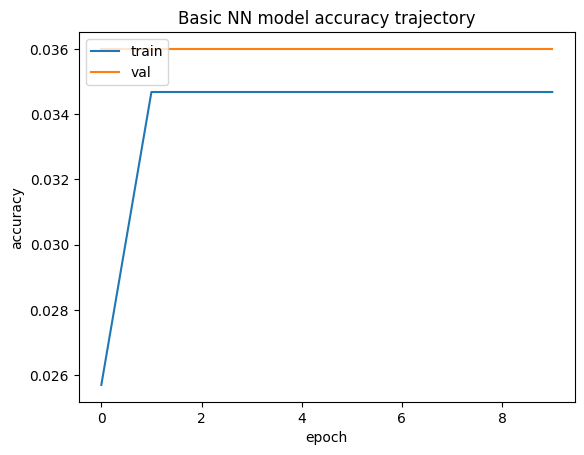

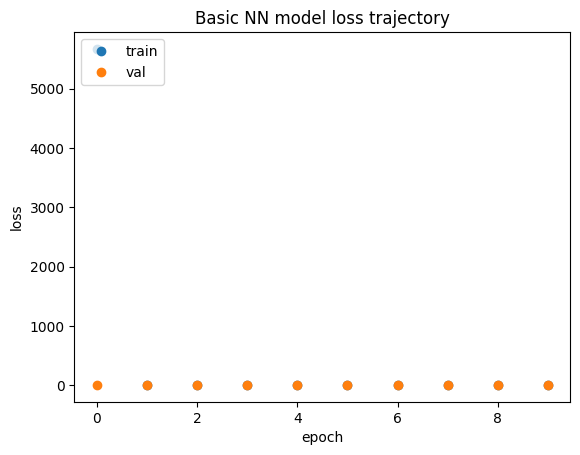

In [14]:
# Plotting accuracy trajectory
plt.plot(ffnn_model_results.history['accuracy'])
plt.plot(ffnn_model_results.history['val_accuracy'])
plt.title('Basic NN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(ffnn_model_results.history['loss'],'o')
plt.plot(ffnn_model_results.history['val_loss'],'o')
plt.title('Basic NN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
## Testing the 2 layer NN model 

nn_score = ffnn_model.evaluate(test_X, test_Y, verbose=0)
print('Test accuracy of the NN model:', nn_score[1])

Test accuracy of the NN model: 0.04268292710185051


One of the main reasons that lead to this poor prediction result of 4.26% is due to the fact that the model is too simple to effectively classify complex images. This FFNN model is a basic 2 layers fully connected neural network that lacks the ability to capture any meaningful spartial relationships and patterns within the images. These images as visualized earlier contained intircate details and local features that required a more sophisticated models, such as convolutional neural network (CNN) to extract and analyze. 

CNNs are specifically designed for image classification tasks as they took the advantage of convolution layers to capture local patterns and heirarchical representation.  In order to improve the prediction accuracy, it is recommended to explore the use of CNNs instead of the FFNN model. By incorporating convolutional and pooling layers, the CNN model would be able to learn and extract relevant features from the license plate images, leading to more accurate predictions. Additionally, increasing the complexity of the model by adding more layers or adjusting the architecture can also enhance its predictive performance.

### (iii)(c) Training Model 3 (Keras ResNet50)

The third model that we constructed is "ResNet50 model", which is a deep convolutional neural network architecture best known for its excellent performance in image classification tasks. This model provided by Keras has been pre-trained on the large-scale ImageNet dataset with millions of labeled images across various categories. For this model, we define the shape of the input images to be (367, 1000, 3) since ResNet50 model only works on images with more than 1 color channel. Similarly, we also applied a flatten later to flatten the output from the base model followed by a dense process that take these flattened output and produce the final classfication probabilities for the 51 classes.

In [16]:
#res net needs more than 1 color channel
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(367, 1000, 3))
x = base_model.output
x = Flatten()(x)
predictions = Dense(51, activation='softmax')(x) 

resnet_model = Model(inputs=base_model.input, outputs=predictions)
resnet_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 367, 1000,   0           []                               
                                3)]                                                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 373, 1006, 3  0           ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_conv (Conv2D)            (None, 184, 500, 64  9472        ['conv1_pad[0][0]']              
                             

In [21]:
# Model parameters
learning_rate = 1e-3
epochs = 6
resnet_optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
resnet_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=resnet_optimizer,
                 metrics=['accuracy'])

train_X_3layer = np.repeat(train_X[..., np.newaxis], 3, -1)
valid_X_3layer = np.repeat(valid_X[..., np.newaxis], 3, -1)

# Training and validating the model
resnet_model_results = resnet_model.fit(train_X_3layer,
             train_Y,
             batch_size=3,
             epochs=epochs,
             validation_data=(valid_X_3layer, valid_Y), verbose=True)

Epoch 1/6
817/817 [==============================] - 45s 48ms/step - loss: 0.2244 - accuracy: 0.9853 - val_loss: 5.6666 - val_accuracy: 0.8060
Epoch 2/6
817/817 [==============================] - 38s 47ms/step - loss: 0.1331 - accuracy: 0.9874 - val_loss: 3.9948 - val_accuracy: 0.8880
Epoch 3/6
817/817 [==============================] - 38s 47ms/step - loss: 0.0743 - accuracy: 0.9935 - val_loss: 3.0978 - val_accuracy: 0.9020
Epoch 4/6
817/817 [==============================] - 38s 47ms/step - loss: 0.0622 - accuracy: 0.9947 - val_loss: 5.9638 - val_accuracy: 0.8460
Epoch 5/6
817/817 [==============================] - 38s 47ms/step - loss: 0.1092 - accuracy: 0.9927 - val_loss: 5.1684 - val_accuracy: 0.8700
Epoch 6/6
817/817 [==============================] - 38s 47ms/step - loss: 0.0567 - accuracy: 0.9955 - val_loss: 4.0256 - val_accuracy: 0.8960


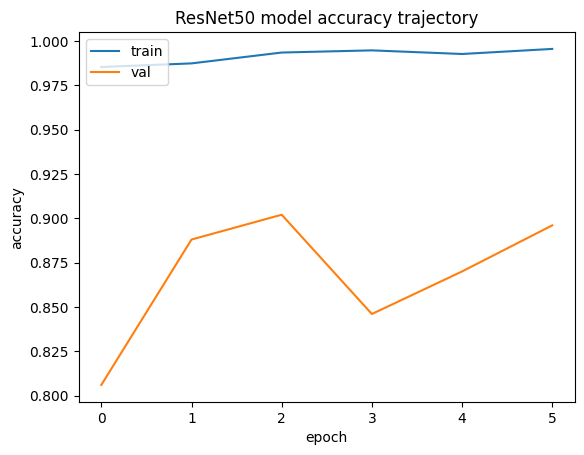

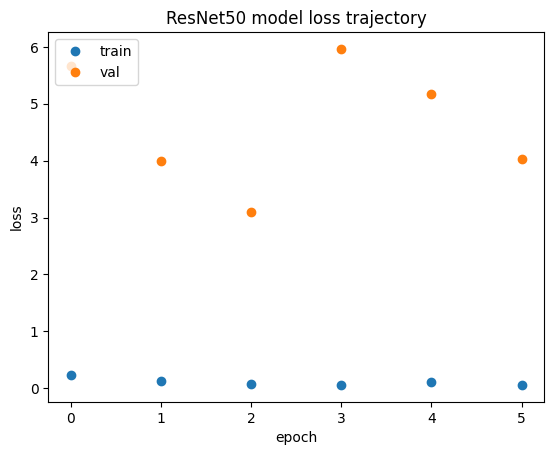

In [22]:
# Plotting accuracy trajectory
plt.plot(resnet_model_results.history['accuracy'])
plt.plot(resnet_model_results.history['val_accuracy'])
plt.title('ResNet50 model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(resnet_model_results.history['loss'],'o')
plt.plot(resnet_model_results.history['val_loss'],'o')
plt.title('ResNet50 model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
test_X_3layer = np.repeat(test_X[..., np.newaxis], 3, -1)
rnet_score = resnet_model.evaluate(test_X_3layer, test_Y)
print('Test accuracy of the ResNet model:', rnet_score[1])

11/11 [==============================] - 1s 78ms/step - loss: 7.0531 - accuracy: 0.8598
Test accuracy of the ResNet model: 0.8597561120986938


### (iv) Model Comparison and Visualization

In [27]:
from sklearn.metrics import f1_score

y_pred_prob = cnn_model_1.predict(test_X)
y_pred = np.argmax(y_pred_prob, axis=1)
f1 = f1_score(test_Y, y_pred, average = "weighted")
print("CNN F1 score:", f1)

y_pred_prob = ffnn_model.predict(test_X)
y_pred = np.argmax(y_pred_prob, axis=1)
f1 = f1_score(test_Y, y_pred, average = "weighted")
print("NN F1 score:", f1)

y_pred_prob = resnet_model.predict(test_X_3layer)
y_pred = np.argmax(y_pred_prob, axis=1)
f1 = f1_score(test_Y, y_pred, average = "weighted")
print("ResNet F1 score:", f1)

11/11 [==============================] - 0s 28ms/step
CNN F1 score: 0.7900854991197013
11/11 [==============================] - 0s 4ms/step
NN F1 score: 0.003504756455189185
11/11 [==============================] - 1s 79ms/step
ResNet F1 score: 0.8618627123496676


We used train, validation, and test accuracy as our evaluation metrices. We will compare the performance of the models by comparing the mentioned evaluation metrices. The following grid displays the overall best acurracies, and do note that they are not from same epochs as the accuracies are very similar to each other when they are at the maximum.

  <table>
  <tr>
    <th>Model</th>
    <th>Train Accuracy</th>
    <th>Validation Accuracy</th>
    <th>Test Accuracy</th>
  </tr>
  <tr>
    <td>CNN (Model 1)</td>
    <td>0.98</td>
    <td>0.82</td>
    <td>0.79</td>
  </tr>
  <tr>
    <td>NN (Model 2)</td>
    <td>0.034</td>
    <td>0.036</td>
    <td>0.04</td>
  </tr>
  <tr>
    <td>ResNet (Model 3)</td>
    <td>0.995</td>
    <td>0.896</td>
    <td>0.859</td>
  </tr>
</table>

Although determining the best-performing model is challenging, we can conclude that Model 2 performed poorly due to its lack of layers. Networks with more layers can capture spatial and local features more effectively. Unfortunately, our basic NN model had only two layers, leading to subpar performance in the task. We can also note that by a slight margin, ResNet outperformed CNN in our case. CNN is known for its strong feature extraction capabilities in image processing tasks, while ResNet excels with large datasets and addresses the vanishing gradient problem. As our task involved image processing on a relatively large dataset, ResNet architecture contributed to its better performance compared to CNN.

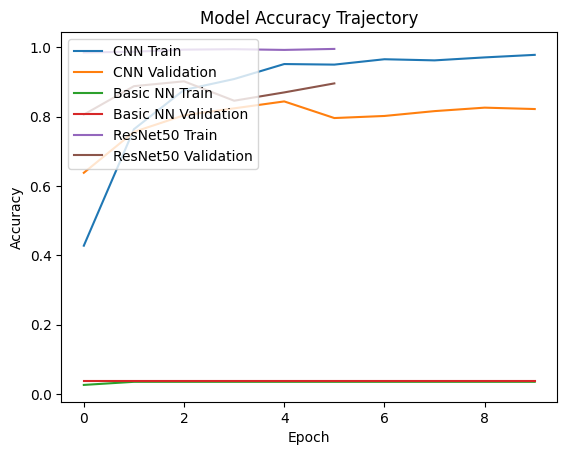

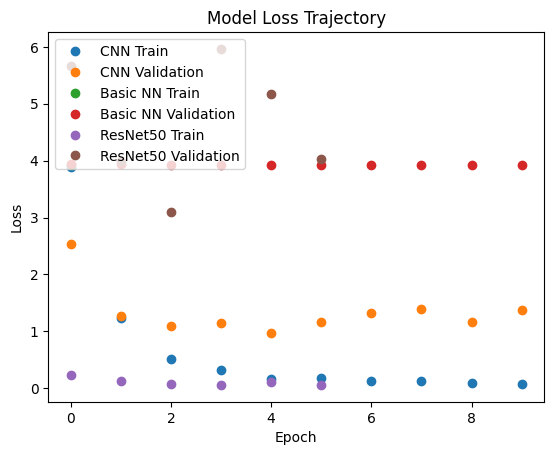

In [29]:
#This combines accuracy graphs together, and loss graphs together. I can't run it because I haven't trained the other ones! pls run it when u can and delete this comment!

# Plotting accuracy trajectory
plt.plot(cnn_model_1_results.history['accuracy'])
plt.plot(cnn_model_1_results.history['val_accuracy'])
plt.plot(ffnn_model_results.history['accuracy'])
plt.plot(ffnn_model_results.history['val_accuracy'])
plt.plot(resnet_model_results.history['accuracy'])
plt.plot(resnet_model_results.history['val_accuracy'])

plt.title('Model Accuracy Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CNN Train', 'CNN Validation', 'Basic NN Train', 'Basic NN Validation', 'ResNet50 Train', 'ResNet50 Validation'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_1_results.history['loss'],'o')
plt.plot(cnn_model_1_results.history['val_loss'],'o')
plt.plot(ffnn_model_results.history['loss'][-1],'o')
plt.plot(ffnn_model_results.history['val_loss'],'o')
plt.plot(resnet_model_results.history['loss'],'o')
plt.plot(resnet_model_results.history['val_loss'],'o')

plt.title('Model Loss Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['CNN Train', 'CNN Validation', 'Basic NN Train', 'Basic NN Validation', 'ResNet50 Train', 'ResNet50 Validation'], loc='upper left')
plt.show()